<H3>Part I: demo of facilities</H3>

**A) Indexing facilities**

*A.1 Preprocessing options: statistics*

In [5]:
import os, os.path
import re
import sys
import time
from sklearn.feature_extraction.text import CountVectorizer
from math import log
import math
from nltk import sent_tokenize
import operator
import matplotlib.pyplot as plt 
import itertools
import zipfile as zf
import spacy
from scipy import spatial, sparse 
import nltk
nltk.download('punkt')

inv_index = {}
idfs = {}
n_docs = 0
term_count = {}
avg_dl = 0

def file_body_processing(filebody): 
    filebody = re.sub(r"[\n]+[.]",'. ',filebody)
    filebody = re.sub(r"[:][-][')']",'',filebody)    
    filebody = re.sub(r"[\'][\']", '\"', filebody)
    filebody = re.sub(r"S.T.A.L.K.E.R.",'',filebody)
    filebody = re.sub(r"[' '][\n]+",'\n',filebody)
    filebody = re.sub(r"[\"][\n]+",'\" ',filebody)
    filebody = re.sub(r"[!][\n]+",'! ',filebody)
    filebody = re.sub(r"[?][\n]+",'? ',filebody)
    filebody = re.sub(r"[:][\n]+",': ',filebody)
    filebody = re.sub(r"[.][\n]+",'. ',filebody)
    filebody = re.sub(r"[\n]+",'. ',filebody)
    return filebody

def add_noun_phrases(filebody,filename):
  nlp = spacy.load('en_core_web_sm')
  doc = nlp(filebody)
  count_noun_phrases = 0
  for noun_phrase in doc.noun_chunks:
    if inv_index.get(noun_phrase.text) == None:
      inv_index[noun_phrase.text] = [(filename,filebody.count(noun_phrase.text))]
    else:
      inv_index[noun_phrase.text].append((filename,filebody.count(noun_phrase.text)))
    count_noun_phrases+=1
  term_count[filename] += count_noun_phrases

def index_document(filename, preprocessing): 
  global n_docs, avg_dl
  file = open(filename,"rb")
  filebody = file.read().decode(errors='replace')
  if preprocessing == "bigram":
    vectorizer = CountVectorizer(analyzer = "word", ngram_range=(1,2))
  else:
    vectorizer = CountVectorizer()
  X = vectorizer.fit_transform([filebody])
  fileterms = vectorizer.get_feature_names_out()
  avg_dl += len(fileterms)
  term_count[filename] = len(fileterms)
  matrix = X.toarray()[0]
  for token in fileterms:
      if inv_index.get(token) == None:
          inv_index[token] = [(filename,matrix[vectorizer.vocabulary_[token]])]
      elif filename not in inv_index[token]:
          inv_index[token].append((filename,matrix[vectorizer.vocabulary_[token]]))
  n_docs += 1
  if preprocessing == "noun_phrases":
    add_noun_phrases(filebody,filename)
  file.close()

def indexing(D,preprocessing): 
  global n_docs, avg_dl
  start = time.time()
  for dirName, subdirList, fileList in os.walk(D):
      for name in fileList:
          index_document(os.path.join(dirName, name),preprocessing)
  end = time.time()
  avg_dl = avg_dl / n_docs
  time_passed = end-start
  print("Indexing time: %.2fs." % time_passed)
  print("Indexing memory space: " + str(sys.getsizeof(inv_index)) + " bytes.")
  print("Number of indexed terms: " + str(len(inv_index.keys())) + ".")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


*A.2 Indexing statistics*

Creating inverted index using a term-only approach, and printing memory/time statistics. Further ahead, statistics will be presented to bigram and noun-phrase indexing.

In [25]:
# Unziping directory
home = os.path.expanduser("~")
files = zf.ZipFile("BBC News Summary.zip", 'r')
files.extractall("")
files.close()

# Indexing and respective statistics. Change the preprocessing value for different inverted index construction strategies.
preprocessing = "simple" # Possible values: 'simple', 'bigram', 'noun_phrases'
indexing("BBC News Summary"+os.sep+"News Articles",preprocessing)

Indexing time: 23.56s.
Indexing memory space: 20971624 bytes.
Number of indexed terms: 381390.


**B) Ranking facilities**

*B.1 Summarization solution: results for a given document*

In [7]:
# Function to calculate idf of specific term.
def idf(term):
    global n_docs 
    N = n_docs + 1 # total number of documents
    df = len(inv_index[term]) # total number of documents where term appears
    result = math.log10(N/df)
    return result

# Function to calculate idf of all terms in inverted index.
def store_idfs():
    for term in inv_index.keys():
        idfs[term] = idf(term)

# Function to build summary in text from given (sentence:relevance_value) hashmap of the full text.        
def build_summary(sentence_dict,l):
    summary = ""
    char_count = 0
    sentence_count = 0
    for entry in sentence_dict.keys():
        char_count += len(entry)
        if char_count < l:
            summary += entry
            sentence_count += 1
        else:
            break
    return summary,sentence_count       

# Function to create summary using term frequency model.
def create_tf_dict(sentences,d, textprocessing):
    tf_dict = {}
    total_term_count = term_count[d]
    for sentence in sentences:
        term_tf = 0
        if textprocessing == "bigram":
            vectorizer = CountVectorizer(analyzer = "word", ngram_range=(1,2))
        else:
            vectorizer = CountVectorizer()
        X = vectorizer.fit_transform([sentence])
        fileterms = vectorizer.get_feature_names_out()
        for term in fileterms:
            for doc in inv_index[term]:
                if doc[0] == d:
                    tn = doc[1]
            term_tf += 1 + math.log10(tn)
        tf_dict[sentence] = term_tf / sparse.csr_matrix.sum(X)
    return tf_dict

# Function to create summary using tfidf model.
def create_tfidf_dict(sentences,d,textprocessing):
    tfidf_dict = {}
    total_term_count = term_count[d]
    for sentence in sentences:
        #print("Sentence:" + sentence)
        term_tfidf = 0
        if textprocessing == "bigram":
            vectorizer = CountVectorizer(analyzer = "word", ngram_range=(1,2))
        else:
            vectorizer = CountVectorizer()
        X = vectorizer.fit_transform([sentence])
        fileterms = vectorizer.get_feature_names_out()
        for term in fileterms:
            for doc in inv_index[term]:
                if doc[0] == d:
                    tn = doc[1]
            term_tfidf += idfs[term] * (1 + math.log10(tn))
        tfidf_dict[sentence] = term_tfidf / sparse.csr_matrix.sum(X)
    return tfidf_dict

# Function to create summary using bm25 model.
def create_bm25_dict(sentences,d,textprocessing):
    bm25_dict = {}
    total_term_count = term_count[d]
    for sentence in sentences:
        term_bm25 = 0
        if textprocessing == "bigram":
            vectorizer = CountVectorizer(analyzer = "word", ngram_range=(1,2))
        else:
            vectorizer = CountVectorizer()
        X = vectorizer.fit_transform([sentence])
        fileterms = vectorizer.get_feature_names_out()
        for term in fileterms:
            for doc in inv_index[term]:
                if doc[0] == d:
                    tn = doc[1]
            term_bm25 += (idfs[term] * (2.2 * tn)) / (tn + 1.2 * (0.25 + 0.75 * (total_term_count / avg_dl)))
        bm25_dict[sentence] = term_bm25 / sparse.csr_matrix.sum(X)
    return bm25_dict

# Main ranking function.
def ranking(d,order,I,p=8,l=500,model="tfidf",textprocessing=None):
    file = open(d,"r")
    filebody = file.read()
    filebody = file_body_processing(filebody)
    sentences = sent_tokenize(filebody)
    if model == "tfidf":
        sentence_dict = create_tfidf_dict(sentences,d,textprocessing)
    elif model == "tf":
        sentence_dict = create_tf_dict(sentences,d,textprocessing)
    else:
        sentence_dict = create_bm25_dict(sentences,d,textprocessing)
    sorted_dict = dict(sorted(sentence_dict.items(), key=operator.itemgetter(1),reverse=True))
    full_dict = sorted_dict
    min_relevance = 0
    if p <= len(sentence_dict.keys()):
        min_relevance =  sentence_dict[list(sorted_dict)[p-1]]
    if order == "relevance":
        sentence_dict = dict(itertools.islice(sorted_dict.items(), p))
    else:
        temp_dict = {}
        for sentence in sentence_dict.keys():
            if sentence_dict[sentence] >= min_relevance:
                temp_dict[sentence] = sentence_dict[sentence]
        sentence_dict = temp_dict
    summary, sentence_count = build_summary(sentence_dict,l)
    sentence_dict = dict(itertools.islice(sentence_dict.items(), sentence_count))
    file.close()
    return (summary,sentence_dict, full_dict)

store_idfs()

# Summary using tfidf example

filename = "BBC News Summary" + os.sep + "News Articles" + os.sep + "tech" + os.sep + "001.txt"
summarytfidf, summary_dict_tfidf, full_rank_tfidf = ranking(filename,"relevance",inv_index,model="tfidf")
print("TF-IDF Summary:\nSummary length: " + str(len(summary_dict_tfidf.keys())) + " sentences (" + str(len(summarytfidf)) + " characters).\n")
summarytfidf

TF-IDF Summary:
Summary length: 4 sentences (432 characters).



"Ink helps drive democracy in Asia.The ink is sprayed on a person's left thumb.Widely circulated articles compared the use of ink to the rural practice of marking sheep - a still common metaphor in this primarily agricultural society.The Kyrgyz Republic, a small, mountainous state of the former Soviet republic, is using invisible ink and ultraviolet readers in the country's elections as part of a drive to prevent multiple voting."

*B.2 Classic IR models: differences*

In this section, summaries for a specific file are presented, highlighting the differences between generating them using different IR models.

In [8]:
# Summary using tf example

summarytf,summary_dict_tf, full_rank_tf = ranking(filename,"relevance",inv_index,model="tf")
print("Term-Frequency Summary\nSummary length: " + str(len(summary_dict_tf.keys())) + " sentences (" + str(len(summarytf)) + " characters).\n")
summarytf

Term-Frequency Summary
Summary length: 8 sentences (495 characters).



'The use of "invisible" ink is not without its own problems.The use of ink and readers by itself is not a panacea for election ills.The ink is sprayed on a person\'s left thumb.The use of ink has been controversial - especially among groups perceived to be pro-government.Ink helps drive democracy in Asia.It dries and is not visible under normal light.The actual technology behind the ink is not that complicated.The country\'s widely watched parliamentary elections are scheduled for 27 February.'

In [9]:
# Summary using bm25 example

summarybm25,summary_dict_bm25, full_rank_bm25 = ranking(filename,"relevance",inv_index,model="bm25")
print("BM25 Summary\nSummary length: " + str(len(summary_dict_bm25.keys())) + " sentences (" + str(len(summarybm25)) + " characters).\n")
summarybm25

BM25 Summary
Summary length: 4 sentences (415 characters).



"Ink helps drive democracy in Asia.The ink is sprayed on a person's left thumb.The Kyrgyz Republic, a small, mountainous state of the former Soviet republic, is using invisible ink and ultraviolet readers in the country's elections as part of a drive to prevent multiple voting.Local newspapers have carried stories that the ink is harmful, radioactive or even that the ultraviolet readers may cause health problems."

*B.3 Reciprocal rank funsion*

Example of summary created using RRF for the three previously generated summaries: 

In [10]:
rank_list = [full_rank_tfidf,full_rank_tf,full_rank_bm25]

def rrf(rank_list):
  aggregated_rank = {}
  for sentence in rank_list[0].keys():
    rank = 1/(0.5 + rank_list[0][sentence])
    for model in rank_list[1:]:
      rank += 1/(0.5 + model[sentence])
    aggregated_rank[sentence] = rank
  sorted_rank = dict(sorted(aggregated_rank.items(), key=operator.itemgetter(1),reverse=False))
  return sorted_rank

aggregated_rank = rrf(rank_list)
build_summary(aggregated_rank,1000)[0]

'Ink helps drive democracy in Asia.The ink is sprayed on a person\'s left thumb.The use of ink and readers by itself is not a panacea for election ills.The Kyrgyz Republic, a small, mountainous state of the former Soviet republic, is using invisible ink and ultraviolet readers in the country\'s elections as part of a drive to prevent multiple voting.The use of "invisible" ink is not without its own problems.Widely circulated articles compared the use of ink to the rural practice of marking sheep - a still common metaphor in this primarily agricultural society.Local newspapers have carried stories that the ink is harmful, radioactive or even that the ultraviolet readers may cause health problems.If the ink shows under the UV light the voter will not be allowed to enter the polling station.Likewise, any voter who refuses to be inked will not receive the ballot.It dries and is not visible under normal light.The country\'s widely watched parliamentary elections are scheduled for 27 Februar

*B.4 Maximal Marginal Relevance*

Example of summary created with MMR:




In [11]:
def create_mmr_rank(original_sentences,current_sentences,lb,summary):
  mmr_rank = {}
  original_doc = ''.join(original_sentences)
  current_doc = ''.join(current_sentences)
  for sentence in current_sentences:
    vectors = [original_doc,sentence,current_doc] 
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(vectors)
    sentence_vector = X.toarray()[1]
    curr_vector = X.toarray()[2]
    doc_similarity = spatial.distance.cosine(curr_vector,sentence_vector)
    aux = 0
    rank = (1 - lb) * doc_similarity 
    for summary_sentence in summary:
      vectors = [original_doc,summary_sentence] 
      vectorizer = CountVectorizer()
      X = vectorizer.fit_transform(vectors)
      summary_sentence_vector = X.toarray()[1]
      sentence_similarity = spatial.distance.cosine(sentence_vector,summary_sentence_vector)
      aux += sentence_similarity
    rank -= lb * aux
    mmr_rank[sentence] = rank
    sorted_mmr_rank = dict(sorted(mmr_rank.items(), key=operator.itemgetter(1),reverse=True)) 
    return sorted_mmr_rank

def create_mmr_summary(original_sentences,current_sentences,lb,mmr_rank,summary,p,l):
  if mmr_rank == None:
    return summary
  most_relevant_sentence = list(mmr_rank.keys())[0]
  if p > 0 and (len(most_relevant_sentence) <= l):
    summary.append(most_relevant_sentence)
    p -= 1
    l -= len(most_relevant_sentence)
    current_sentences.remove(most_relevant_sentence)
    new_mmr_rank = create_mmr_rank(original_sentences,current_sentences,lb,summary)
    return create_mmr_summary(original_sentences,current_sentences,lb,new_mmr_rank,summary,p,l) 
  return summary 

def get_mmr_summary(doc,lb):
  file = open(doc,"r")
  filebody = file.read()
  filebody = file_body_processing(filebody)
  sentences = sent_tokenize(filebody)
  original_sentences = sentences.copy()
  mmr_rank = create_mmr_rank(original_sentences,sentences,lb,[])
  return create_mmr_summary(original_sentences,sentences,lb,mmr_rank,[],8,500)

summary = get_mmr_summary("BBC News Summary" + os.sep + "News Articles" + os.sep + "tech" + os.sep + "001.txt",0.5)  
for sentence in summary:
  display(sentence)


'Ink helps drive democracy in Asia.'

"The Kyrgyz Republic, a small, mountainous state of the former Soviet republic, is using invisible ink and ultraviolet readers in the country's elections as part of a drive to prevent multiple voting."

'This new technology is causing both worries and guarded optimism among different sectors of the population.'

**C) Sentence higlighting facilities**

In this section, an HTML visualization is created for a specific document, highlighting the generated summary.

In [12]:
from IPython.display import display, HTML, IFrame
import os

def visualize(d,order,I,p=8,l=500,model="tfidf"):
    summary,sentence_dict,full_dict= ranking(d,order,I,p,l,model)
    file = open(d,"r")
    filebody = file.read()
    filebody = file_body_processing(filebody)
    sentences = sent_tokenize(filebody)
    file.close()
    if order == "relevance":
        dict_list = list(sentence_dict)
    color = 255
    for sentence in sentences:
        if sentence_dict.get(sentence) != None:
            if order == "relevance":
                curr_color = color - 30 * dict_list.index(sentence)
                display(HTML('<div style="color: rgb(0,' + str(curr_color) + ',0)"> <b>' + sentence + '</b></div>'))
            else:
                display(HTML('<b>' + sentence + '</b>'))
        else:
            display(HTML('<div>' + sentence + '</div>'))
    file.close()
    return summary

print("Sentences with higher relevance appear in brighter colors.\n\nSummary for " + filename + ":\n")
summary = visualize(filename,"relevance",inv_index)

Sentences with higher relevance appear in brighter colors.

Summary for BBC News Summary/News Articles/tech/001.txt:



**D) Evaluation facilities**

*D.1 Evaluation options*

In [17]:
def build_precision_recall_graph(doc,recall, precision, p, l): 
    font1 = {'family':'serif','color':'blue','size':20}
    font2 = {'family':'serif','color':'darkred','size':15}
    if p != None: 
        plt.title("precision-recall for " + str(p) + " sentence(s)",font1)
    else: 
        plt.title("precision-recall for " + str(l) + " characters",font1)
    plt.xlabel("recall", font2)
    plt.ylabel("precision", font2)
    plt.plot(recall,precision)
    if(len(recall) == 0 ): 
        return 
    plt.show()

def build_precision_recall_curve(doc,ref_summary_sentences, summary_sentences, p, l): 
    total_retrieved_docs = 0
    relevant_retrieved_docs = 0
    recall = []
    precision = []
    f_measure = []
    for sentence in summary_sentences:
        total_retrieved_docs +=1
        if sentence in ref_summary_sentences: 
            relevant_retrieved_docs +=1 
            current_recall = relevant_retrieved_docs / len(ref_summary_sentences)
            recall.append(current_recall)
            current_precision = relevant_retrieved_docs / total_retrieved_docs
            precision.append(current_precision)
            f_measure.append(1.25*((current_precision*current_recall)/(0.25 * current_precision+current_recall)))
    mean_fmeasure = sum(f_measure) / len(f_measure)
    build_precision_recall_graph(doc,recall, precision, p, l)
    return mean_fmeasure

def mean_average_precision(rank, ref_summary_sentences):
    average_precision = 0
    relevant_docs = 0
    total_retrieved_docs = 0
    for sentence in rank:
        total_retrieved_docs += 1
        if sentence in ref_summary_sentences:  
            relevant_docs += 1
            average_precision += relevant_docs / total_retrieved_docs
    if relevant_docs > 0: 
        mean_average_precision = average_precision  / relevant_docs
    else: 
        mean_average_precision = 0
    return mean_average_precision

def plot_map_variation(map, x_axis_name, x_axis_values, doc): 
    if len(map) == 0: 
        return
    plt.title("plot map variation in relation to " + x_axis_name) 
    plt.xlabel(x_axis_name)
    plt.ylabel("map")
    plt.plot(x_axis_values,map)
    filename = "map_variation_in_"+ x_axis_name
    plt.show()

def build_f_measure_graph(mean_f_measure,X,x_axis_name,doc):
    if len(mean_f_measure) == 0: 
        return
    plt.title("plot f_measure in relation to " + x_axis_name) 
    plt.xlabel(x_axis_name)
    plt.ylabel("f_measure")
    plt.plot(X,mean_f_measure)
    filename = "fmeasure_"+ x_axis_name
    plt.show()

def summary_size_evaluation(doc,rank,ref_summary_sentences,P,L):
    map_for_p = []
    mean_f_measure_for_p = []
    for p_value in P:
        sentence_dict = dict(itertools.islice(rank.items(), p_value))
        summary = build_summary(sentence_dict,2500)[0]
        summary = re.sub(r'([a-z])\.([A-Z])', r'\1. \2',summary)
        summary = re.sub(r'([0-9])\.([A-Z])', r'\1. \2',summary)
        summary = re.sub(r'([a-z])\.([0-9])', r'\1. \2',summary)
        summary_sentences = sent_tokenize(summary)
        mean_f_measure = build_precision_recall_curve(doc,ref_summary_sentences,summary_sentences,p_value,None)
        map = mean_average_precision(summary_sentences,ref_summary_sentences)
        map_for_p.append(map)
        mean_f_measure_for_p.append(mean_f_measure)
    plot_map_variation(map_for_p, "p_values", P, doc)
    build_f_measure_graph(mean_f_measure_for_p,P,"p",doc)
    map_for_l = []
    mean_f_measure_for_l = []
    for l_value in L:
        summary = build_summary(rank,l_value)[0]
        summary = re.sub(r'([a-z])\.([A-Z])', r'\1. \2',summary)
        summary = re.sub(r'([0-9])\.([A-Z])', r'\1. \2',summary)
        summary = re.sub(r'([a-z])\.([0-9])', r'\1. \2',summary)
        summary_sentences = sent_tokenize(summary)
        mean_f_measure = build_precision_recall_curve(doc,ref_summary_sentences,summary_sentences,None,l_value)
        map = mean_average_precision(summary_sentences,ref_summary_sentences)
        map_for_l.append(map)
        mean_f_measure_for_l.append(mean_f_measure)
    plot_map_variation(map_for_l,"l_values", L, doc)
    build_f_measure_graph(mean_f_measure_for_l,L,"l",doc)
    return map_for_p, map_for_l

*D.2 Comparison of settings (IR models, preprocessing)*

Evaluation for tfidf using a simple index (without bigrams or noun phrases).

Status:BBC News Summary/News Articles/tech/002.txt


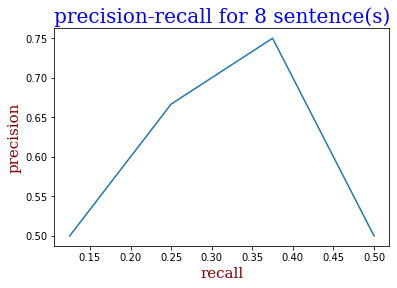

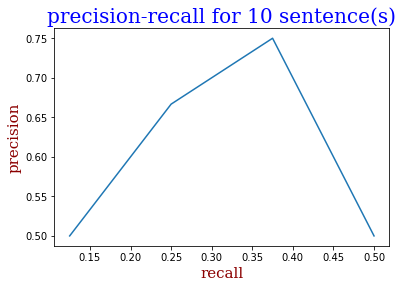

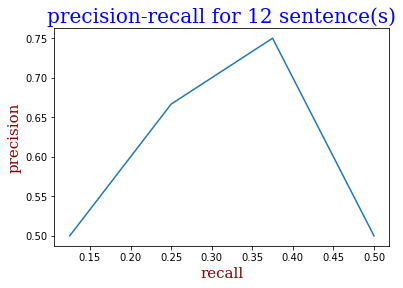

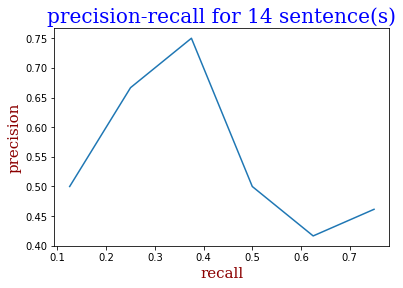

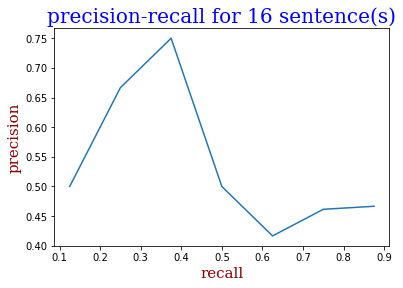

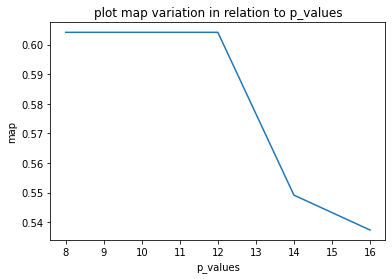

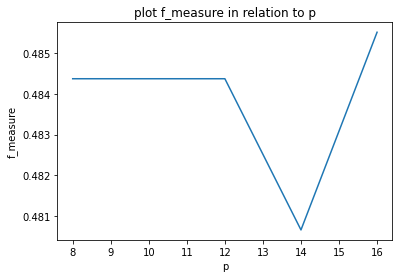

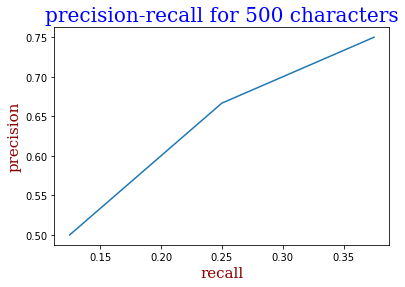

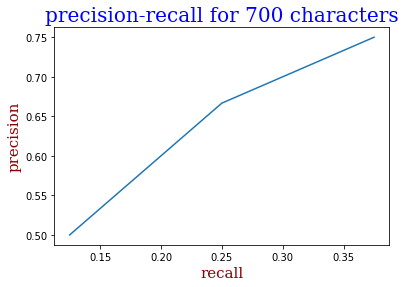

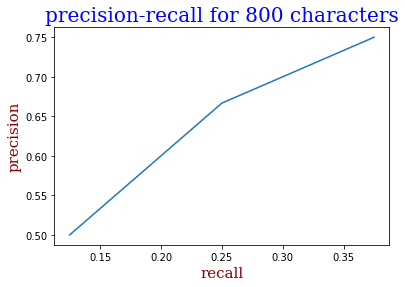

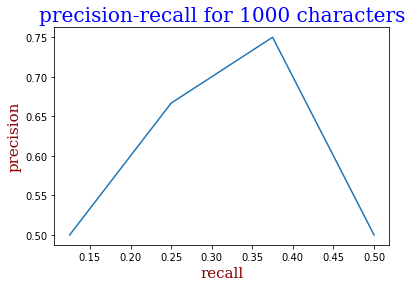

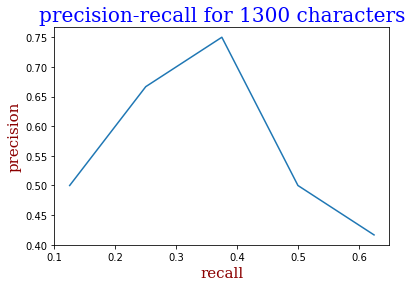

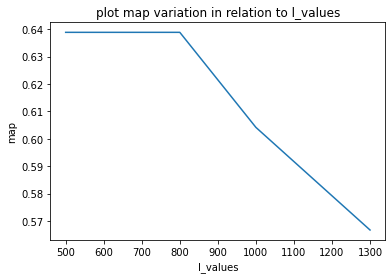

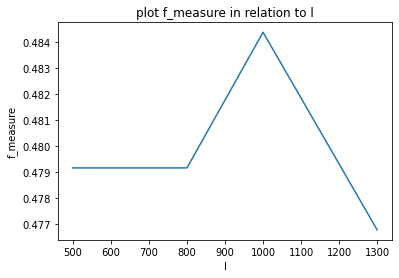

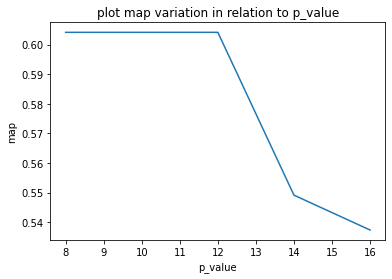

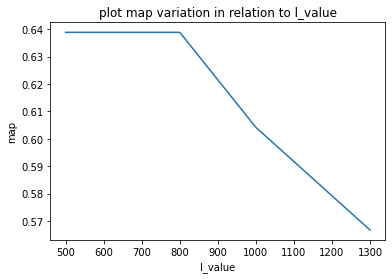

In [18]:
def evaluation(D,S,I,P=[8,10,12,14,16],L=[500,700,800,1000,1300],model="tfidf"):
    map_for_p_docs = []
    i = 0
    for i in range(len(P)): 
        map_for_p_docs.append(0)
    map_for_l_docs = []
    i = 0
    for i in range(len(L)): 
        map_for_l_docs.append(0)
    for doc,summaryfile in zip(D,S):
        print("Status:" + doc)
        full_rank = ranking(doc,"relevance",inv_index,model="tfidf",textprocessing=None)
        rank = full_rank[2]
        file1 = open(summaryfile,"r")
        summarybody = re.sub(r'([a-z])\.([A-Z])', r'\1. \2',file1.read())
        summarybody = re.sub(r'([0-9])\.([A-Z])', r'\1. \2',summarybody)
        summarybody = re.sub(r'([a-z])\.([0-9])', r'\1. \2',summarybody)
        ref_summary_sentences = sent_tokenize(summarybody)
        map_for_p, map_for_l = summary_size_evaluation(doc.split("\\")[-1],rank,ref_summary_sentences,P,L)
        i = 0 
        for i in range(len(map_for_p)): 
            map_for_p_docs[i] += map_for_p[i]
        i = 0
        for i in range(len(map_for_l)): 
            map_for_l_docs[i] += map_for_l[i]        
    i = 0
    for i in range(len(map_for_p_docs)): 
        map_for_p_docs[i] = map_for_p_docs[i] / len(D)
    plot_map_variation(map_for_p_docs, "p_value", P, "general")
    i = 0
    for i in range(len(map_for_l_docs)): 
        map_for_l_docs[i] = map_for_l_docs[i] / len(D)
    plot_map_variation(map_for_l_docs, "l_value", L, "general")
    return 

set_of_docs = ["BBC News Summary" + os.sep + "News Articles" + os.sep + "tech" + os.sep + "002.txt"]
set_of_summaries = ["BBC News Summary" + os.sep + "Summaries" + os.sep + "tech" + os.sep + "002.txt"]
evaluation(set_of_docs,set_of_summaries,inv_index,model="tfidf")

Evaluation for tf using a simple index (without bigrams or noun phrases).

Status:BBC News Summary/News Articles/tech/002.txt


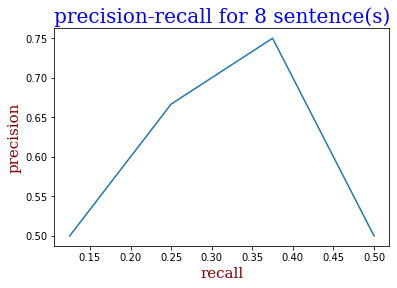

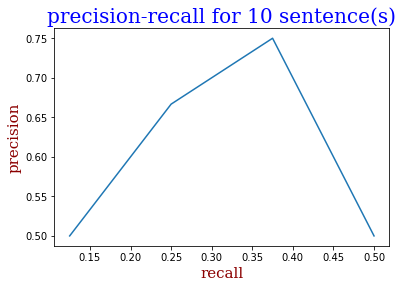

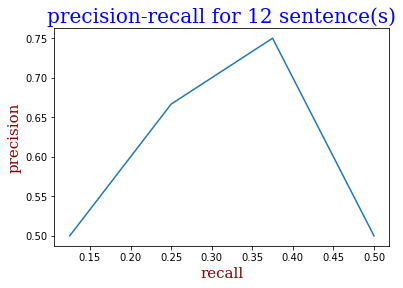

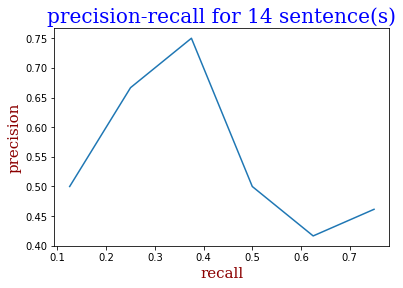

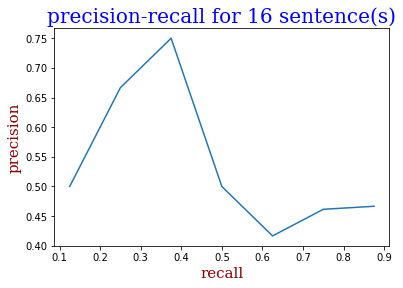

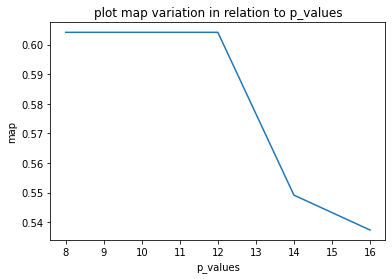

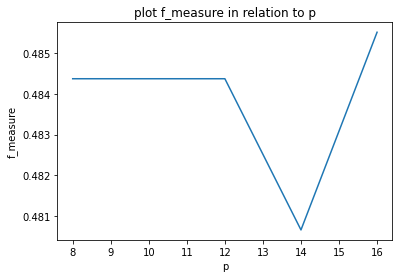

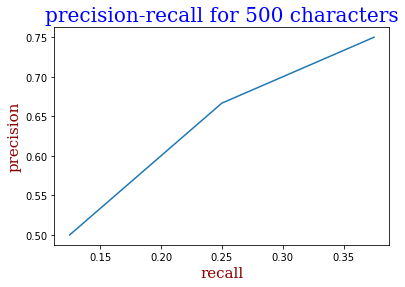

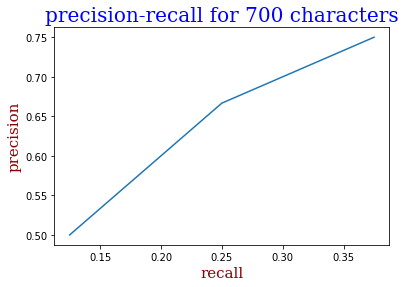

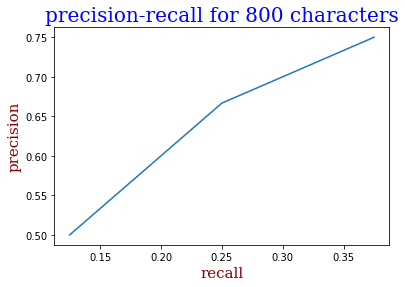

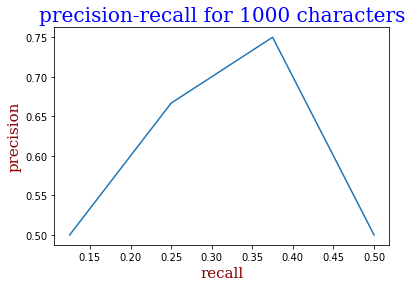

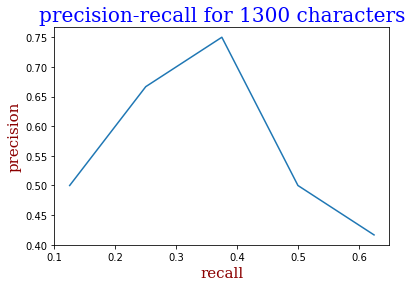

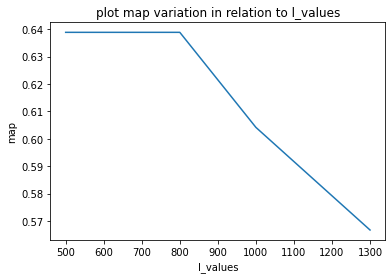

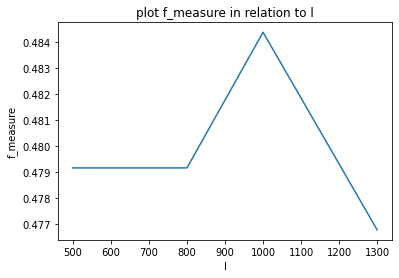

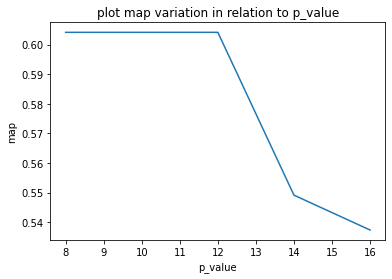

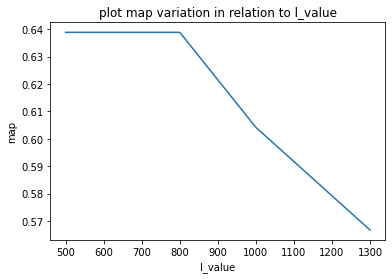

In [19]:
evaluation(set_of_docs,set_of_summaries,inv_index,model="tf")

Evaluation for bm25 using a simple index (without bigrams or noun phrases).

Status:BBC News Summary/News Articles/tech/002.txt


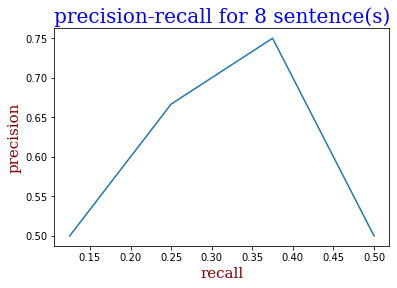

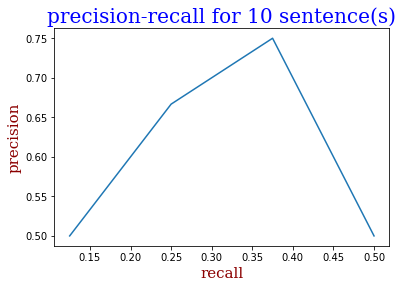

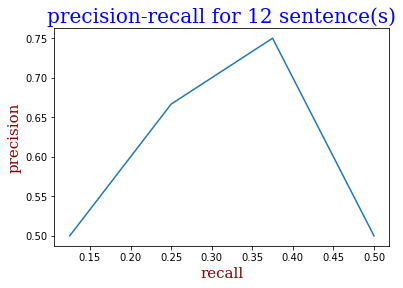

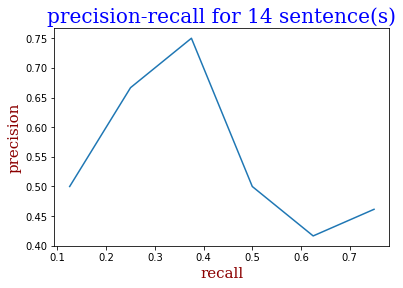

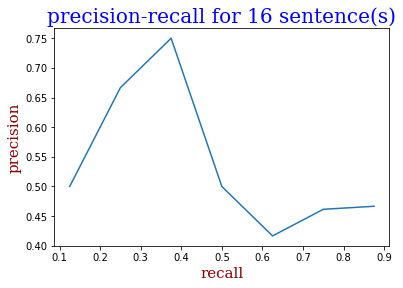

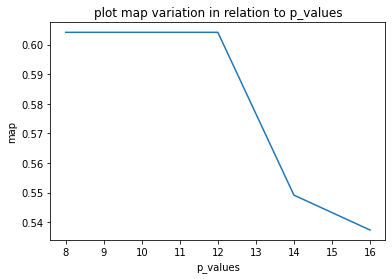

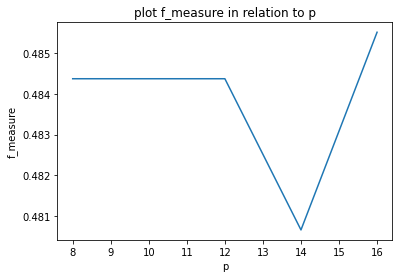

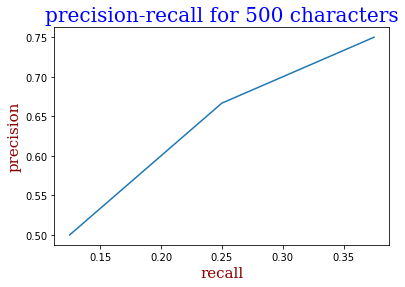

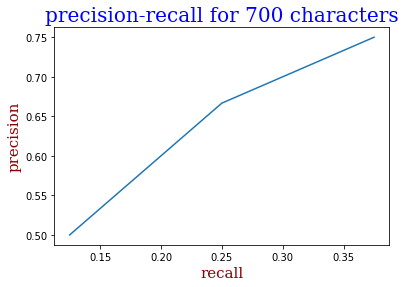

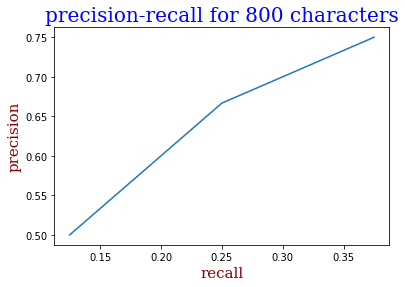

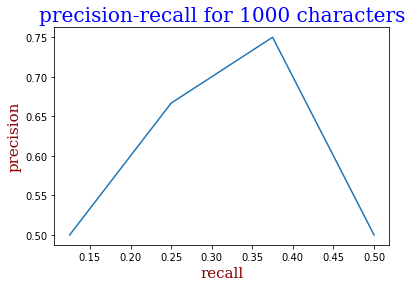

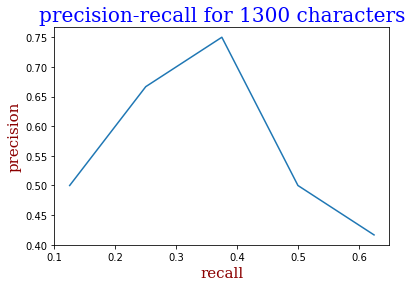

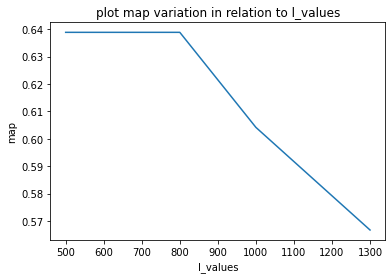

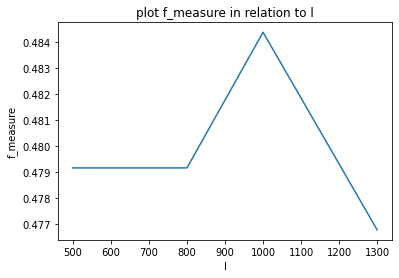

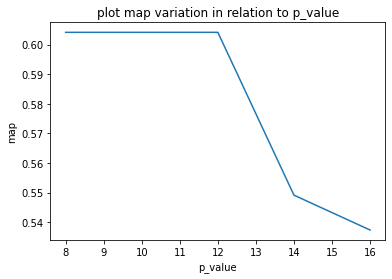

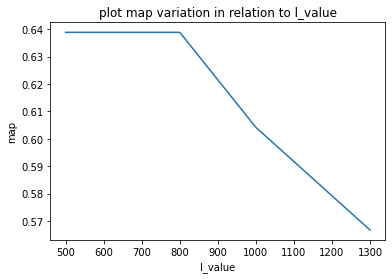

In [20]:
evaluation(set_of_docs,set_of_summaries,inv_index,model="bm25")

Evaluation for tfidf using a bigrams index.

Indexing time: 17.43s.
Indexing memory space: 20971624 bytes.
Number of indexed terms: 359917.
Status:BBC News Summary/News Articles/tech/002.txt


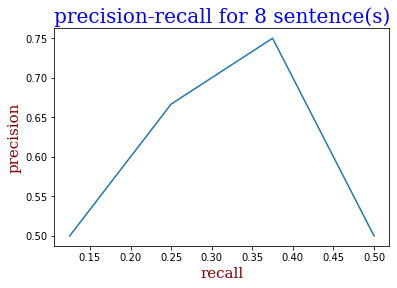

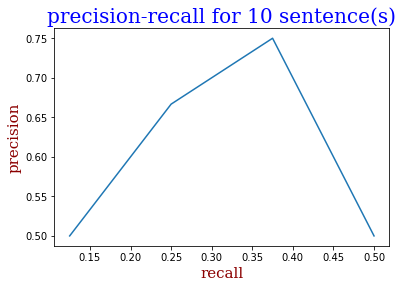

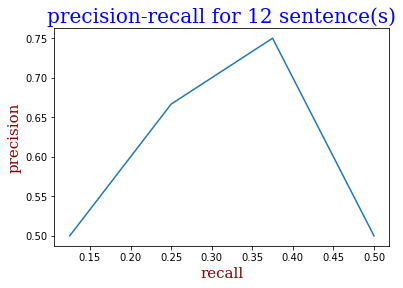

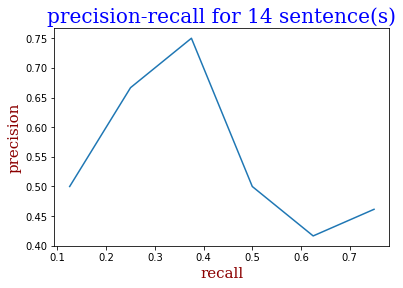

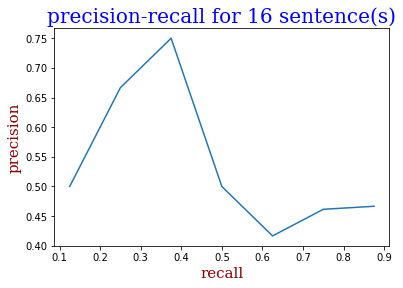

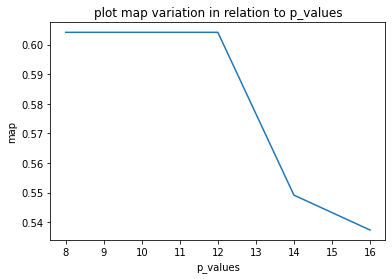

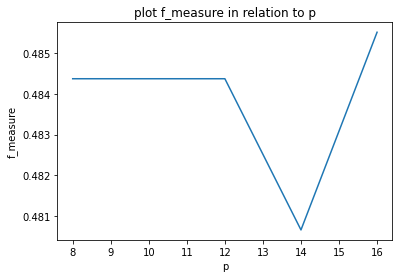

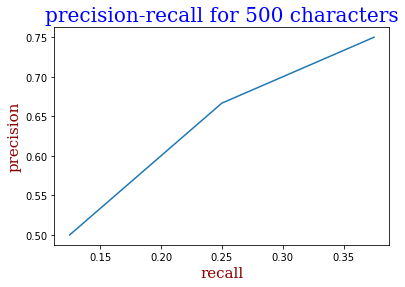

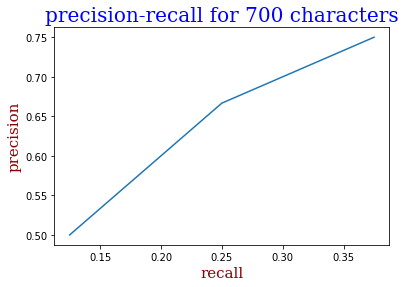

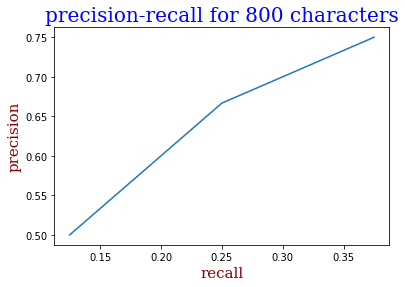

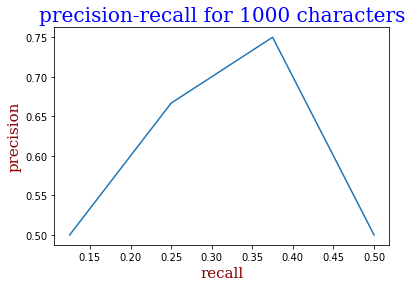

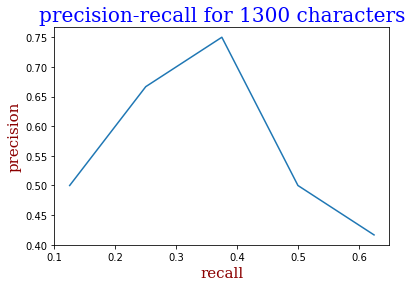

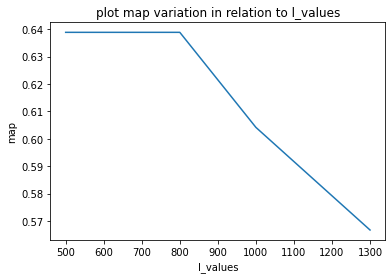

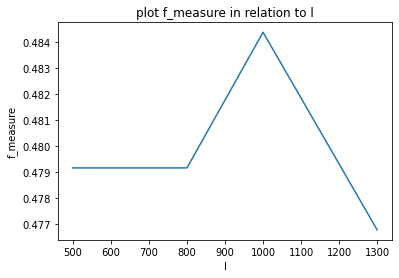

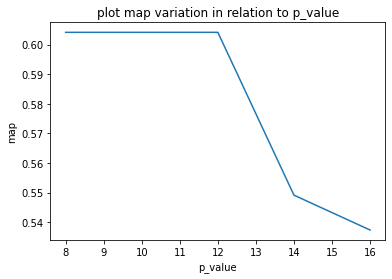

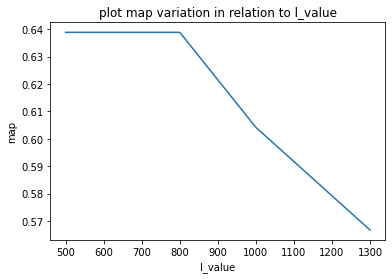

In [26]:
inv_index = {}
indexing("BBC News Summary"+os.sep+"News Articles","bigram")
evaluation(set_of_docs,set_of_summaries,inv_index,model="tfidf")

Evaluation for tf using a bigrams index.

Status:BBC News Summary/News Articles/tech/002.txt


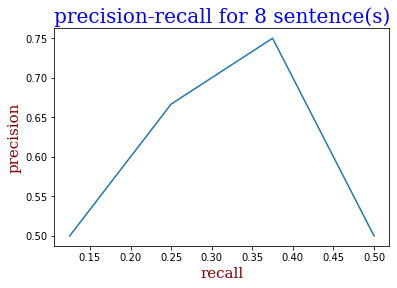

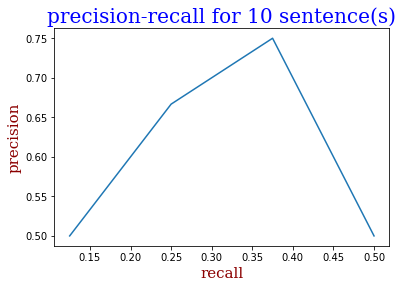

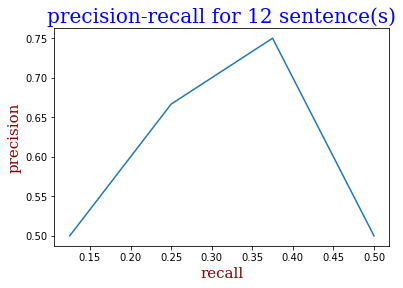

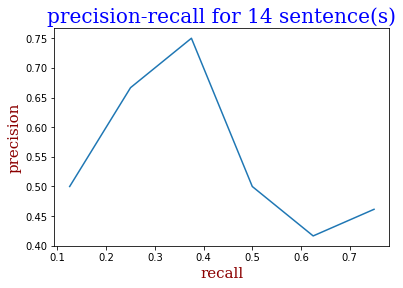

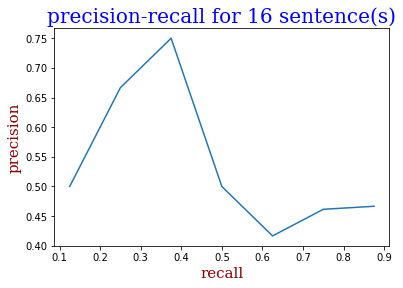

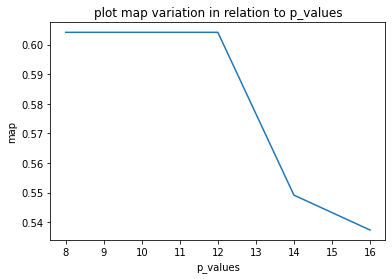

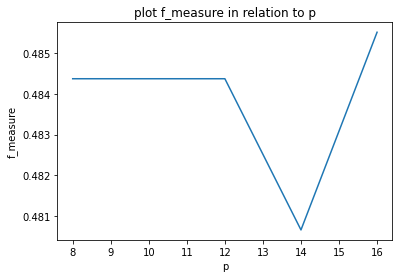

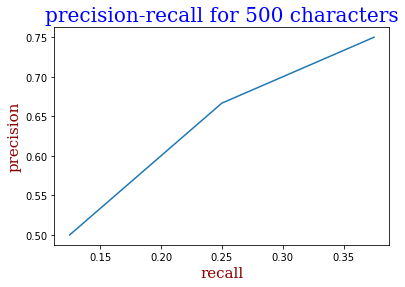

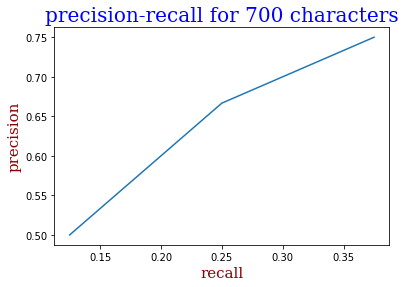

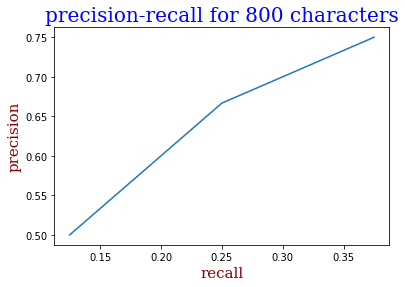

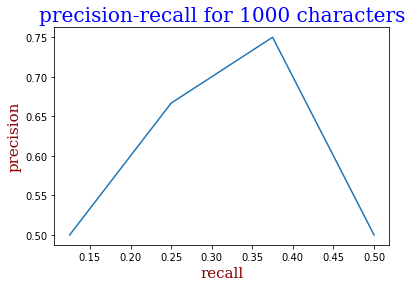

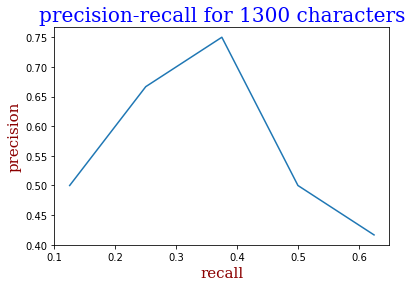

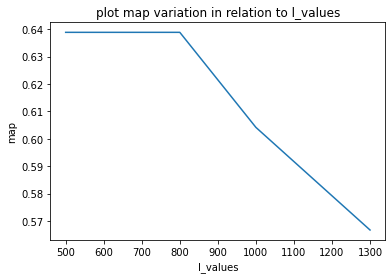

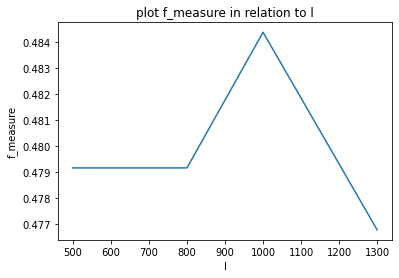

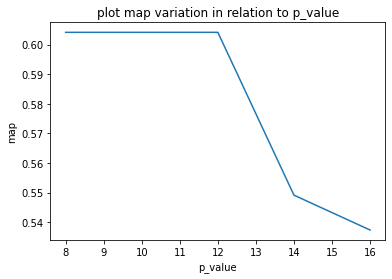

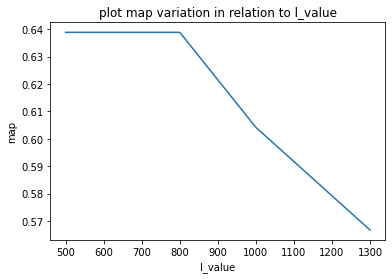

In [27]:
evaluation(set_of_docs,set_of_summaries,inv_index,model="tf")

Evaluation for bm25 using a bigrams index.

Status:BBC News Summary/News Articles/tech/002.txt


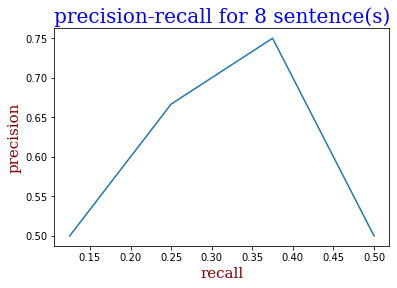

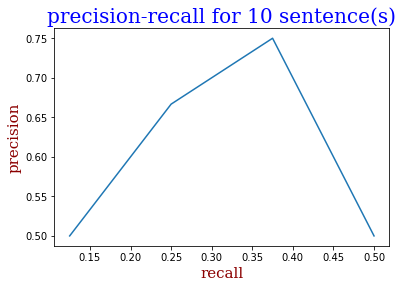

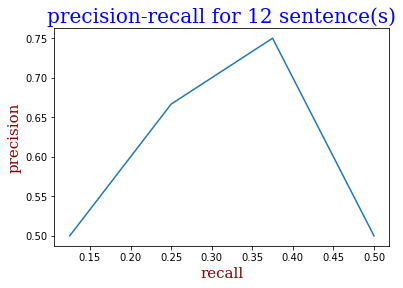

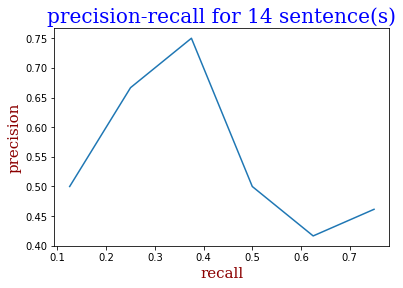

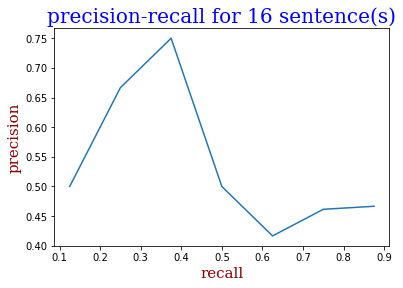

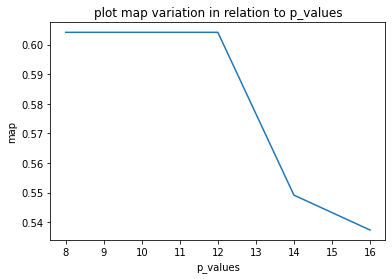

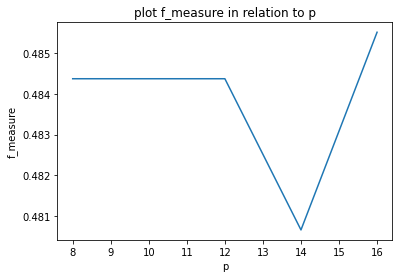

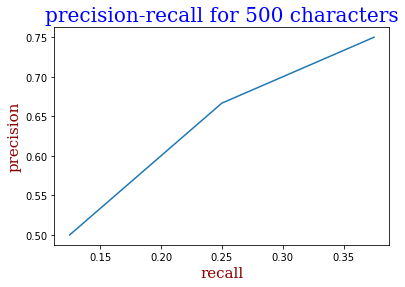

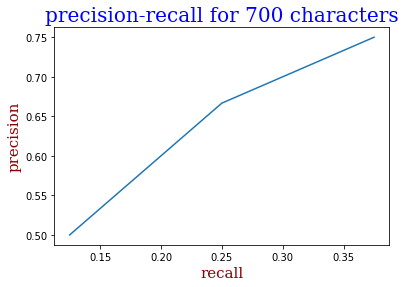

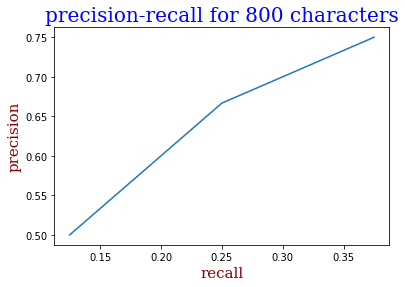

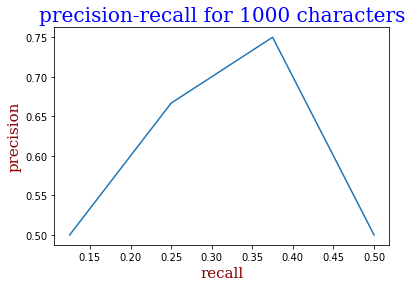

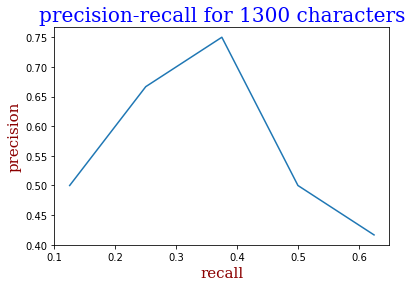

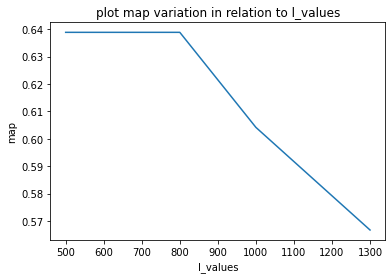

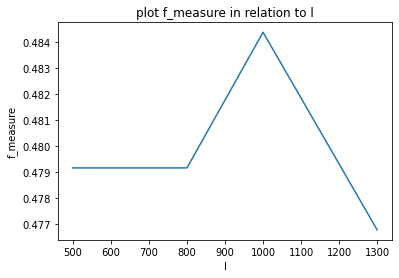

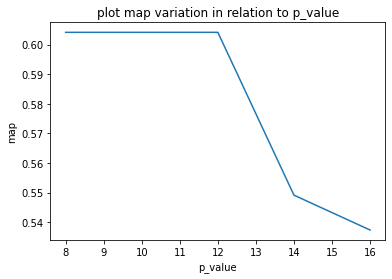

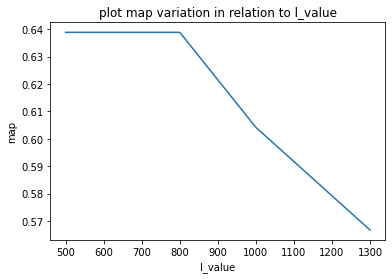

In [28]:
evaluation(set_of_docs,set_of_summaries,inv_index,model="bm25")

Evaluation for tfidf using a noun_phrases index. **This will take a long time to index.**

Indexing time: 1701.54s.
Indexing memory space: 5242984 bytes.
Number of indexed terms: 114425.
Status:BBC News Summary/News Articles/tech/002.txt


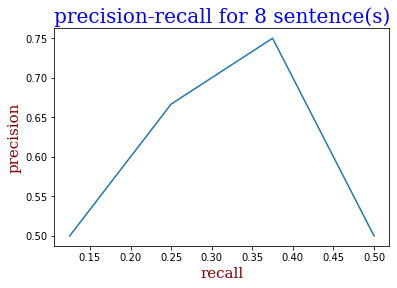

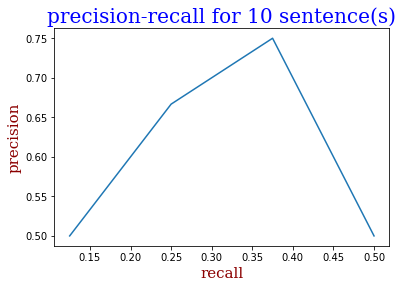

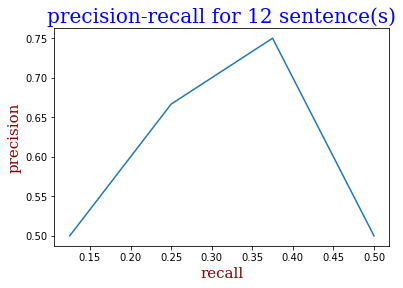

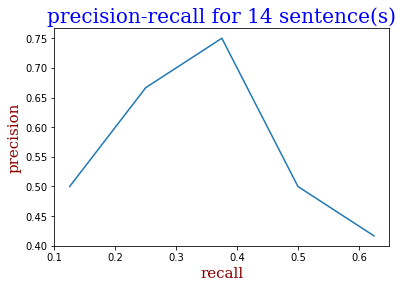

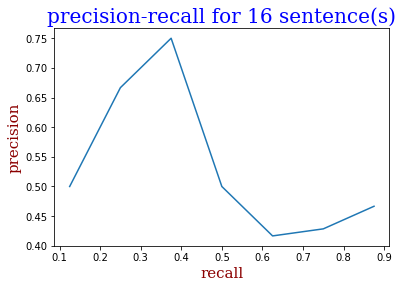

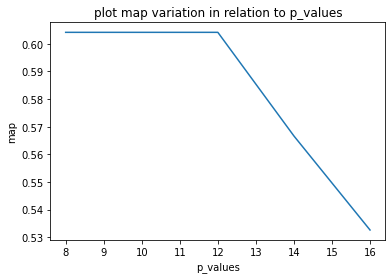

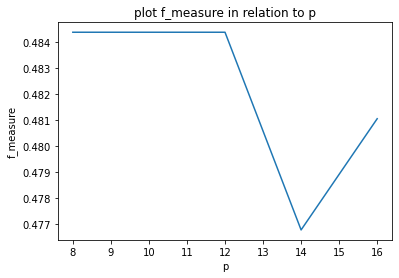

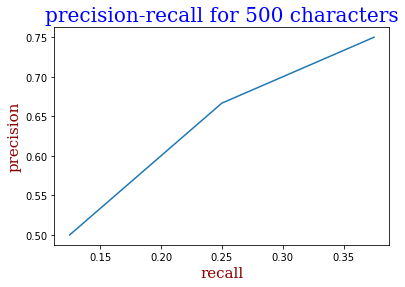

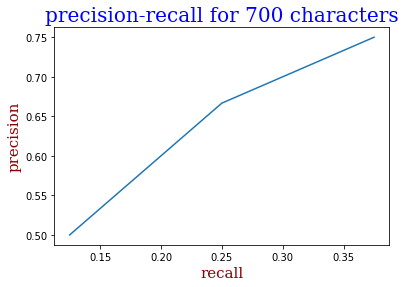

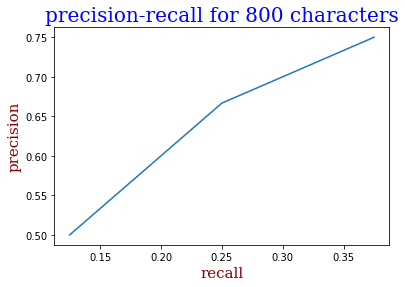

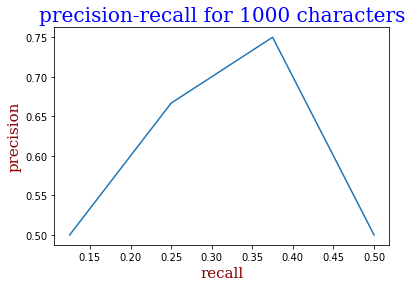

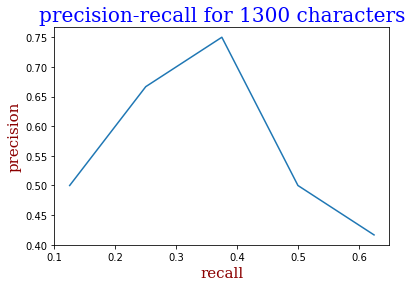

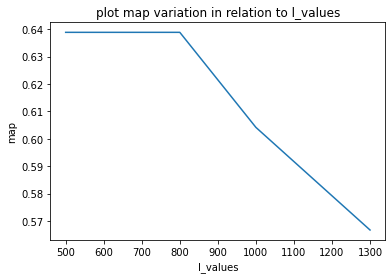

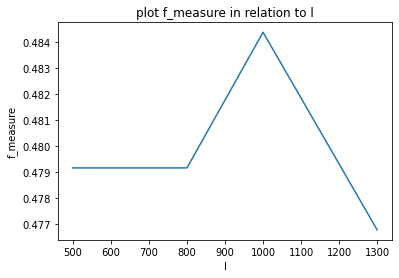

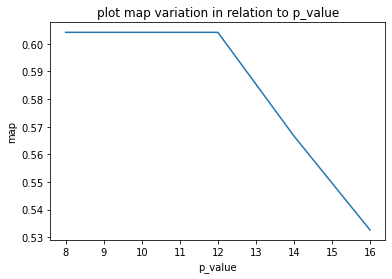

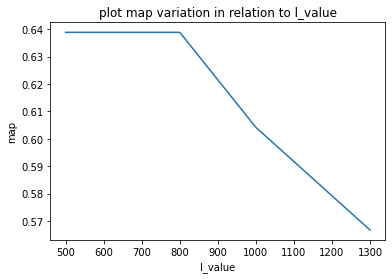

In [29]:
inv_index = {}
indexing("BBC News Summary"+os.sep+"News Articles","noun_phrases")
evaluation(set_of_docs,set_of_summaries,inv_index,model="tfidf")

Evaluation for tf using a noun_phrases index.

Status:BBC News Summary/News Articles/tech/002.txt


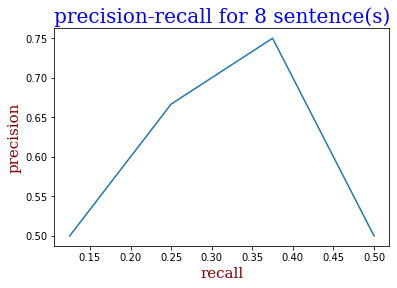

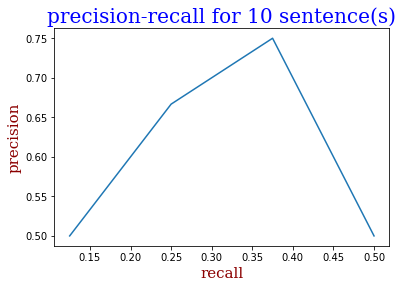

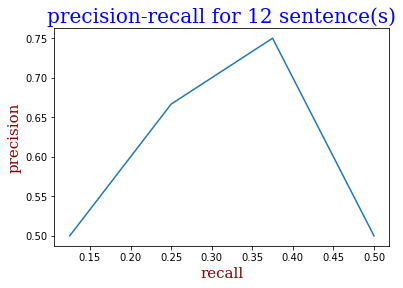

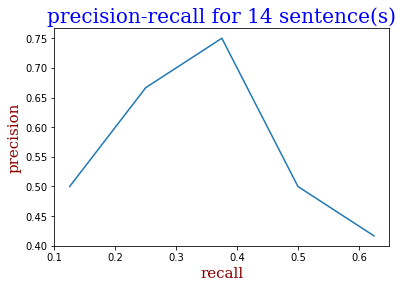

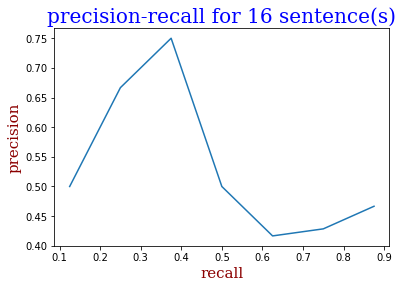

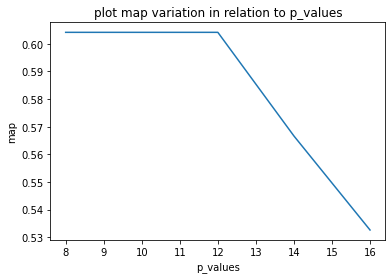

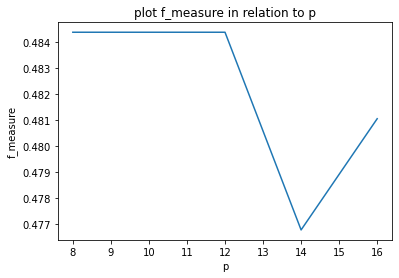

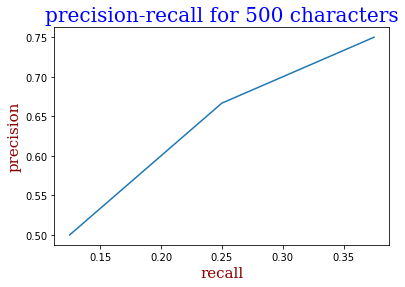

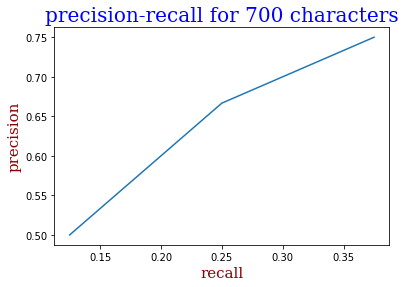

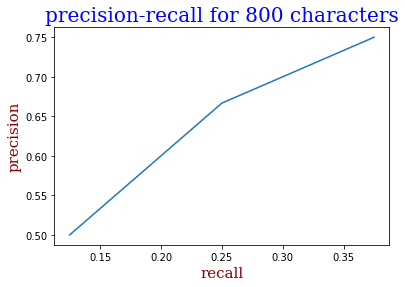

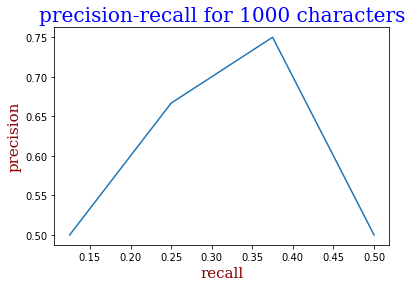

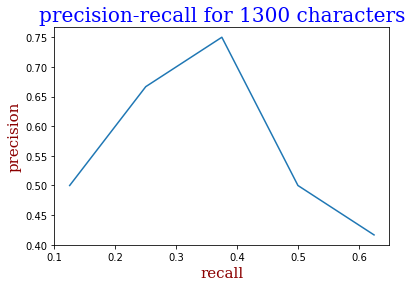

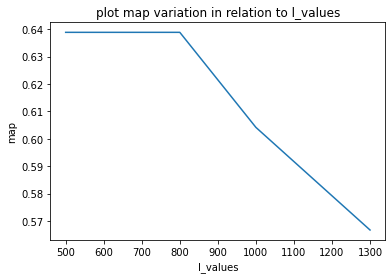

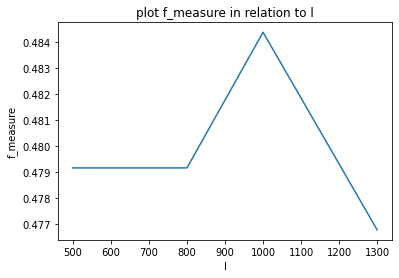

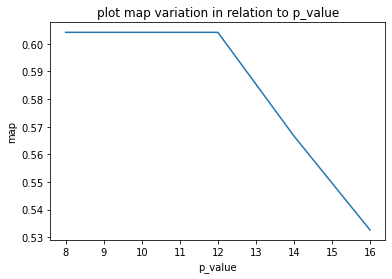

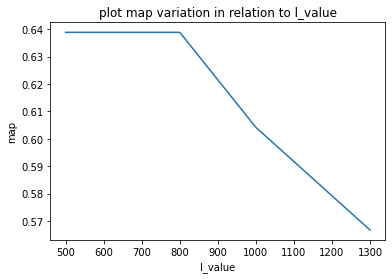

In [32]:
evaluation(set_of_docs,set_of_summaries,inv_index,model="tf")

Evaluation for bm25 using a noun_phrases index.

Status:BBC News Summary/News Articles/tech/002.txt


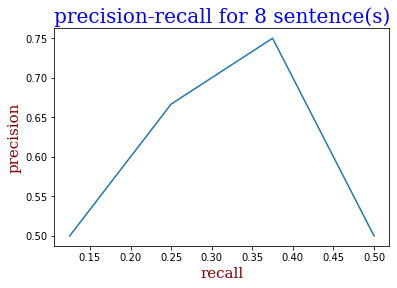

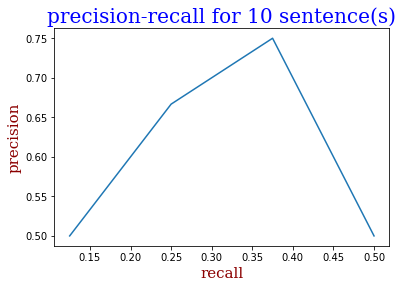

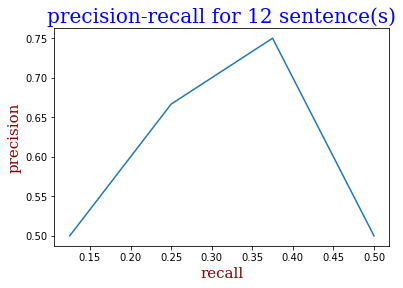

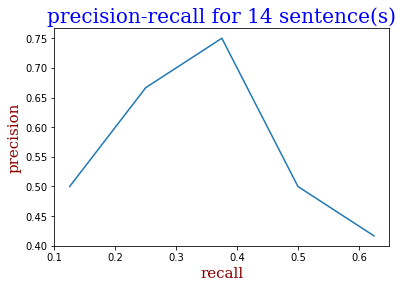

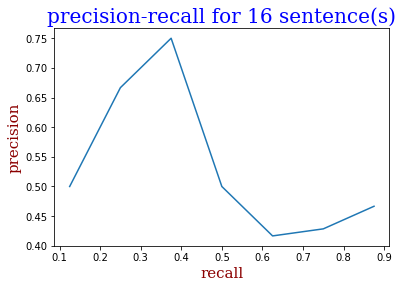

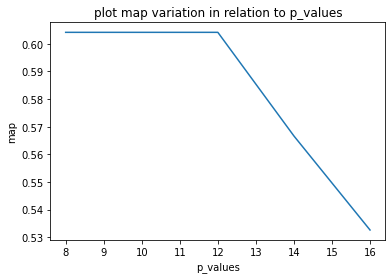

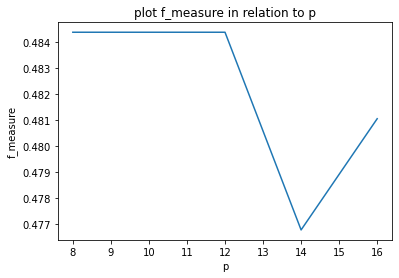

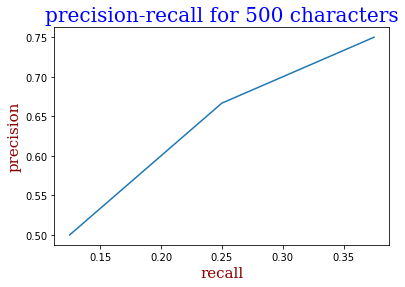

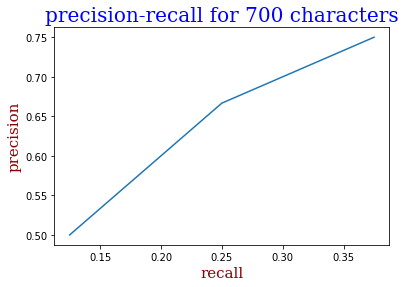

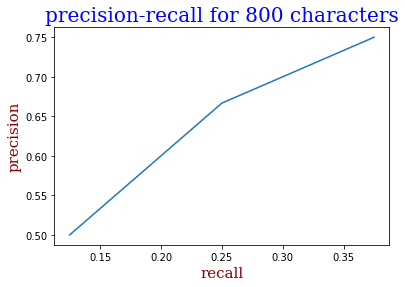

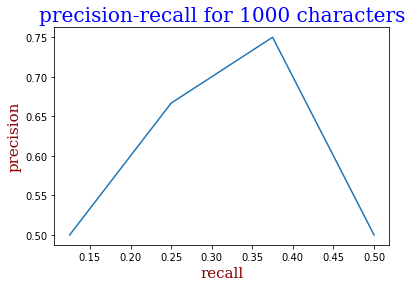

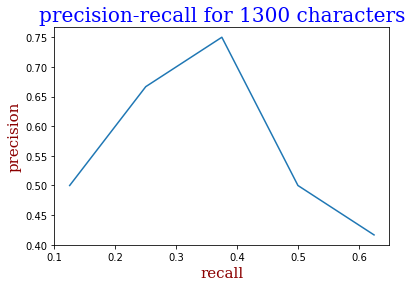

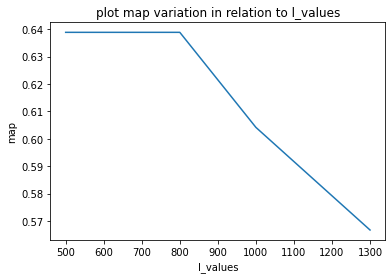

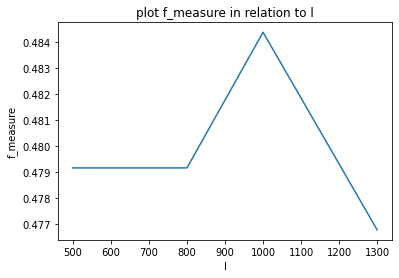

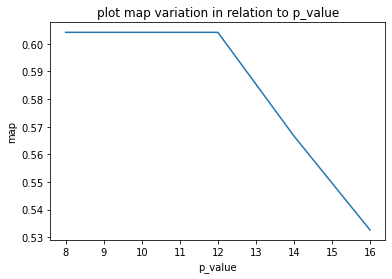

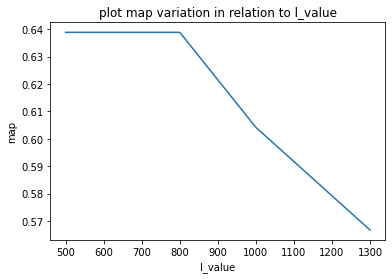

In [33]:
evaluation(set_of_docs,set_of_summaries,inv_index,model="bm25")

<H3>Part II: questions materials (optional)</H3>

**(a)** Corpus and summary description. Distribution of informative terms before and after text processing.

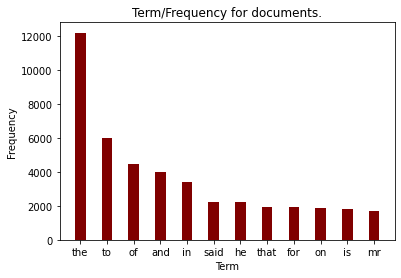

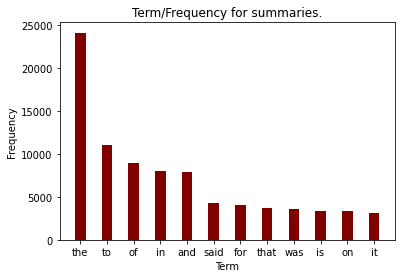

In [34]:
def term_distribution(docs,summaries,args=None):
    docs_content = []
    for dirName, subdirList, fileList in os.walk(docs):
        for name in fileList:
            file = open(os.path.join(dirName,name),"rb")
            docs_content.append(file.read().decode(errors="replace"))
            file.close()
    if args != None:
      vectorizer = CountVectorizer(analyzer = "word", ngram_range=(1,2))
    else:
      vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(docs_content)
    terms = vectorizer.get_feature_names_out()
    term_count = X.toarray().sum(axis=0)
    zip_iterator = zip(terms, term_count)
    sorted_dict = dict(sorted(dict(zip_iterator).items(), key=operator.itemgetter(1),reverse=True))
    sorted_dict = dict(itertools.islice(sorted_dict.items(), 12))
    plt.bar(sorted_dict.keys(), sorted_dict.values(), color ='maroon',
        width = 0.4)
    plt.xlabel("Term")
    plt.ylabel("Frequency")
    plt.title("Term/Frequency for documents.")
    plt.show()
    summaries_content = []
    for dirName, subdirList, fileList in os.walk(summaries):
        for name in fileList:
            file = open(os.path.join(dirName,name),"r")
            summaries_content.append(file.read())
            file.close()
    if args != None:
      vectorizer = CountVectorizer(analyzer = "word", ngram_range=(1,2))
    else:
      vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(summaries_content)
    terms = vectorizer.get_feature_names_out()
    term_count = X.toarray().sum(axis=0)
    zip_iterator = zip(terms, term_count)
    sorted_dict = dict(sorted(dict(zip_iterator).items(), key=operator.itemgetter(1),reverse=True))
    sorted_dict = dict(itertools.islice(sorted_dict.items(), 12))
    plt.bar(sorted_dict.keys(), sorted_dict.values(), color ='maroon',
        width = 0.4)
    plt.xlabel("Term")
    plt.ylabel("Frequency")
    plt.title("Term/Frequency for summaries.")
    plt.show()

docs = "BBC News Summary" + os.sep + "News Articles"+ os.sep + "politics"
summaries = "BBC News Summary"+ os.sep + "Summaries"

term_distribution(docs,summaries,args=None)

<H3>END</H3>